In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization, Conv1D, \
                        MaxPooling1D, GlobalMaxPooling1D 
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import add
#from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
#Read Img Features
infile = open("../input/flickr8k-image-extraction/img_extract.pkl",'rb')
# infile = open("../input/image-captioning-extracting-features/img_extract_inc_3d.pkl",'rb')
img_fea = pickle.load(infile)
infile.close()

In [4]:
len(img_fea['2100735137_05c6079537.jpg'])

2048

In [5]:
#Get All Caps
fn = "../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
f = open(fn, 'r')
capts = f.read()
#Group all captions by filename, for references
captions = dict()
i = 0

try:
    for line in capts.split("\n"):
        txt = line.split('\t')
        fn = txt[0].split('#')[0]
        if fn not in captions.keys():
            captions[fn] = [txt[1]]
        else:
            captions[fn].append(txt[1])
        i += 1
except:
    pass


In [6]:
def getCaptions(path):
    
    f = open(path, 'r')
    capts = f.read()
    desc = dict()

    try:
        for line in capts.split("\n"):
            image_id = line
            image_descs = captions[image_id]

            for des in image_descs:
                ws = des.split(" ")
                w = [word for word in ws if word.isalpha()]
                des = "startseq " + " ".join(w) + " endseq"
                if image_id not in desc:
                    desc[image_id] = list()
                desc[image_id].append(des)
    except:
        pass
    
    return desc

In [7]:
train_caps = getCaptions("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
val_caps = getCaptions("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt")

In [8]:
#preparing to make word-index and index-word
train_captions = []
for key, desc_list in train_caps.items():
    for i in range(len(desc_list)):
        train_captions.append(desc_list[i])

#Tokenize top 5000 words in Train Captions
tokenizer = Tokenizer(num_words=5000,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [9]:
pickle.dump(word_index,open("word_index.pkl","wb"))
pickle.dump(index_word,open("index_word.pkl","wb"))

In [10]:
train_fns = list(train_caps.keys())
train_set = dict((k, img_fea[k]) for k in train_fns)

In [11]:
val_fns = list(val_caps.keys())
val_set = dict((k, img_fea[k]) for k in val_fns)

In [12]:
fn_test = "../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"
f = open(fn_test, 'r')
t = f.read()

test_fns= t.split("\n")
test_set = dict((k, img_fea[k]) for k in list(test_fns[:-1]))

In [13]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [14]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open("../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
vocab_size = len(word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [16]:
# # detect and init the TPU
# import tensorflow as tf
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [17]:
# #Model
# max_length = 34
# # with tpu_strategy.scope():
    
# num_filters = 64  
# inputs1 = Input(shape=(2048,))
# # inputs11 = Reshape((-1, 2048,))(inputs1)
# # conv1 = Conv1D(num_filters, 8, activation='relu', padding='same')(inputs11)
# # maxp = MaxPooling1D(2)(conv1)
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(512, activation='relu')(fe1)
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(512)(se2)

# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.layers[2].set_weights([embedding_matrix])
# model.layers[2].trainable = False
# model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

# epochs = 50
# number_pics_per_batch = 6

# steps = len(train_fns)//number_pics_per_batch

In [18]:

max_length = 34
image_model = Sequential()

image_model.add(Dense(embedding_dim, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_length))

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_dim)))

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model_1 = Model(inputs=[image_model.input, language_model.input], outputs = out)

model_1.layers[2].set_weights([embedding_matrix])
model_1.layers[2].trainable = False

model_1.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

epochs = 50
number_pics_per_batch = 6
steps = len(train_fns)//number_pics_per_batch

In [19]:
#model_1.summary()

In [20]:
# model.summary()

In [21]:
# epochs = 20

In [22]:
start_time = time.time()
val_steps = len(val_fns)//number_pics_per_batch
for i in range(epochs):
    generator = data_generator(train_caps, train_set, word_index, max_length, number_pics_per_batch)
    val_gen = data_generator(val_caps, val_set, word_index, max_length, number_pics_per_batch)
    model_1.fit_generator(generator, validation_data = val_gen, validation_steps = val_steps,
                        epochs=1, steps_per_epoch=steps, verbose=1)
    model_1.save('model_inc_glove.h5')

Epoch 1/1
1000/1000 [==============================] - 138s 138ms/step - loss: 5.5262 - accuracy: 0.1288 - val_loss: 5.3667 - val_accuracy: 0.1674
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 4.8713 - accuracy: 0.1883 - val_loss: 4.9951 - val_accuracy: 0.2069
Epoch 1/1
1000/1000 [==============================] - 136s 136ms/step - loss: 4.5047 - accuracy: 0.2229 - val_loss: 4.6455 - val_accuracy: 0.2363
Epoch 1/1
1000/1000 [==============================] - 140s 140ms/step - loss: 4.2506 - accuracy: 0.2456 - val_loss: 4.4745 - val_accuracy: 0.2559
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 4.0822 - accuracy: 0.2650 - val_loss: 4.3760 - val_accuracy: 0.2713
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 3.4977 - accuracy: 0.3138 - val_loss: 4.0464 - val_accuracy: 0.3082
Epoch 1/1
1000/1000 [==============================] - 132s 132ms/step - loss: 3.4319 - accuracy: 0.3209 - val_loss: 3

In [23]:
# import tempfile

# MODEL_DIR = tempfile.gettempdir()
# version = 1
# export_path = '../working/'
# print('export_path = {}\n'.format(export_path))

# tf.keras.models.save_model(
#     model,
#     export_path,
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None
# )

# print('\nSaved model:')
# !ls -l {export_path}

# # tf.saved_model.save(model, "test/")
# # print("--- %s seconds ---" % (time.time() - start_time))


In [24]:
def createCaption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_1.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    #final = ' '.join(final)
    return final

In [25]:
from nltk.translate.bleu_score import sentence_bleu
def splitCaps(caps):
    s = []
    for c in caps:
        ws = c.split(" ")
        w = [word for word in ws if word.isalpha()]
        s.append(w)
    return s

In [26]:
train_bleu_score = []
for f in train_fns:
    fea = train_set[f]
    candidate = createCaption(fea.reshape((1,2048)))
    reference = splitCaps(captions[f])
    score = sentence_bleu(reference, candidate)
    train_bleu_score.append(score)
    #print(score)
print("Average train bleu score: ", np.mean(train_bleu_score))

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average train bleu score:  0.519779519645071


In [27]:
val_bleu_score = []
for f in val_fns:
    fea = val_set[f]
    candidate = createCaption(fea.reshape((1,2048)))
    reference = splitCaps(captions[f])
    score = sentence_bleu(reference, candidate)
    val_bleu_score.append(score)
    #print(score)
print("Average val bleu score: ", np.mean(val_bleu_score))

Average val bleu score:  0.5147944076725831


In [28]:
from random import seed
from random import randint
# seed random number generator
seed(randint(0,10293))
# generate some integers
photos = []
for _ in range(15):
    value = randint(0, len(val_fns))
    photos.append(value)

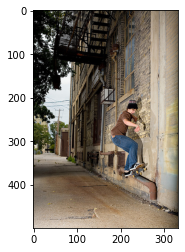

a man wearing a red shirt and black pants is walking down a street


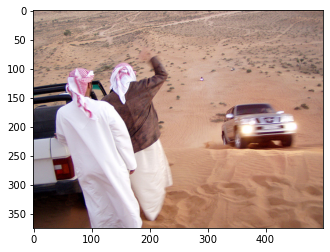

people sit on a bench


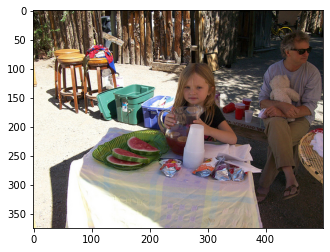

man and a woman sit in a park


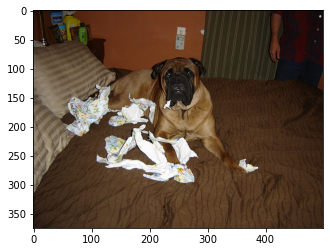

man is standing in front of a cow


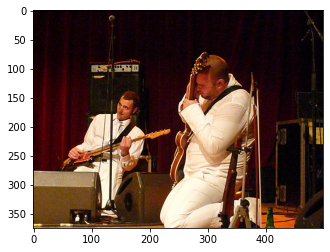

man in a black shirt and black shorts is playing a guitar


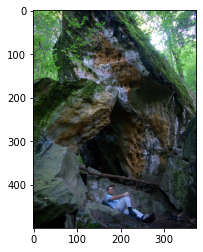

rock climber scales a rock face


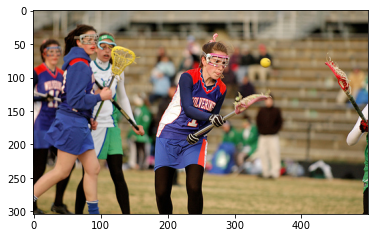

football players are playing with a ball


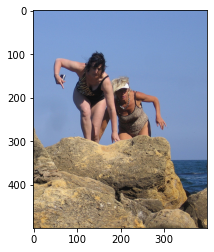

woman in a bikini is standing in front of a large rock formation


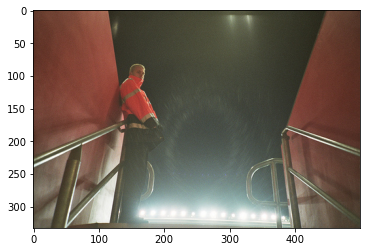

man in a white shirt is jumping a trick on a skateboard


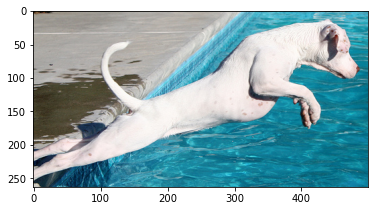

white dog is jumping over a hurdle


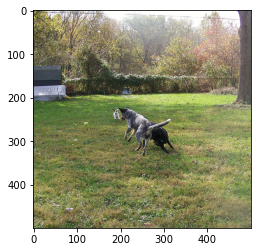

dog running through a field


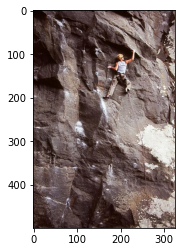

man in a red shirt is climbing a rock


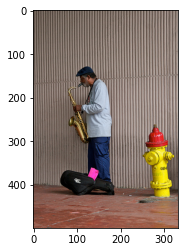

man in a black shirt and jeans is standing on the street


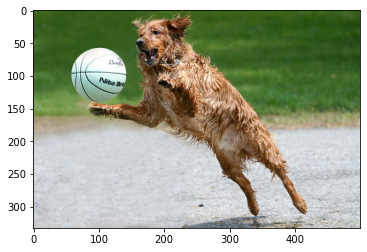

dog is running through the sand


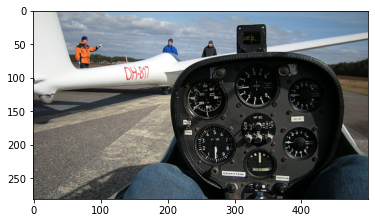

man sits on a white horse


In [29]:
images = "../input/flickr8k/Flickr_Data/Flickr_Data/Images/"
for p in photos:
    sample_test = val_fns[p]
    sample_fea = val_set[sample_test]
    x=plt.imread(images + sample_test)
    plt.imshow(x)
    plt.show()
    a = createCaption((sample_fea).reshape((1,2048)))
    #print(a)
    print(' '.join(a))

In [30]:
# #Model
# max_length = 34
# # with tpu_strategy.scope():
    
# num_filters = 64  
# inputs1 = tf.keras.Input(shape=(2048,))
# # inputs11 = Reshape((-1, 2048,))(inputs1)
# # conv1 = Conv1D(num_filters, 8, activation='relu', padding='same')(inputs11)
# # maxp = MaxPooling1D(2)(conv1)
# fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
# fe2 = tf.keras.layers.Dense(512, activation='relu')(fe1)

# inputs2 = tf.keras.Input(shape=(max_length,))
# se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = tf.keras.layers.Dropout(0.5)(se1)
# se3 = tf.keras.layers.LSTM(512)(se2)

# decoder1 = tf.keras.layers.Add()([fe2, se3])
# decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
# outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
# model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.layers[2].set_weights([embedding_matrix])
# model.layers[2].trainable = False
# model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

# epochs = 1
# number_pics_per_batch = 6
# steps = len(train_fns)//number_pics_per_batch